In [138]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from IPython.display import display

In [146]:
loldata = pd.read_csv('2024_LoL_esports_match_data_from_OraclesElixir_gamedata.csv', sep=';')
lolData_Qtn1_Columns = ['t1_result','t2_result','gamelength','t1p1_champion','t1p2_champion','t1p3_champion','t1p4_champion','t1p5_champion','t2p1_champion','t2p2_champion','t2p3_champion','t2p4_champion','t2p5_champion']
loldataQtn1 = loldata[lolData_Qtn1_Columns].copy()
lolChampdata = pd.read_csv('LoL-Champions.csv')

# Assuming 'loldata' is the name of your DataFrame
dfA = ['t1p1_champion','t1p2_champion','t1p3_champion','t1p4_champion','t1p5_champion']
dfAA = ['t2p1_champion','t2p2_champion','t2p3_champion','t2p4_champion','t2p5_champion']
# Filter rows where t1_result is 1 for Team 1 and t2_result is 1 for Team 2
winning_compositions_t1 = loldataQtn1[loldataQtn1['t1_result'] == 1]
winning_compositions_t2 = loldataQtn1[loldataQtn1['t2_result'] == 1]

dfB = winning_compositions_t1[dfA].copy()
dfC= winning_compositions_t2[dfAA].copy()

# Rename the columns of specific_columns_team1 and specific_columns_team2
dfB.columns = ['P1 Top', 'P2 Jungle', 'P3 Mid', 'P4 Bot', 'P5 Support']
dfC.columns = ['P1 Top', 'P2 Jungle', 'P3 Mid', 'P4 Bot', 'P5 Support']

combined_dataframe = pd.concat([dfB, dfC], ignore_index=True)



This is to merge the '2024_LoL_esports_match_data_from_OraclesElixir_gamedata.csv' with 'LoL-Champions.csv' and get the team compositions of all the teams that won. Saved as 'combined_dataframe'

C:\Users\RajEs\AppData\Local\Temp\ipykernel_45552\4282443417.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_champions.index, rotation=45, ha='right')
C:\Users\RajEs\AppData\Local\Temp\ipykernel_45552\4282443417.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_champions.index, rotation=45, ha='right')
C:\Users\RajEs\AppData\Local\Temp\ipykernel_45552\4282443417.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_champions.index, rotation=45, ha='right')
C:\Users\RajEs\AppData\Local\Temp\ipykernel_45552\4282443417.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

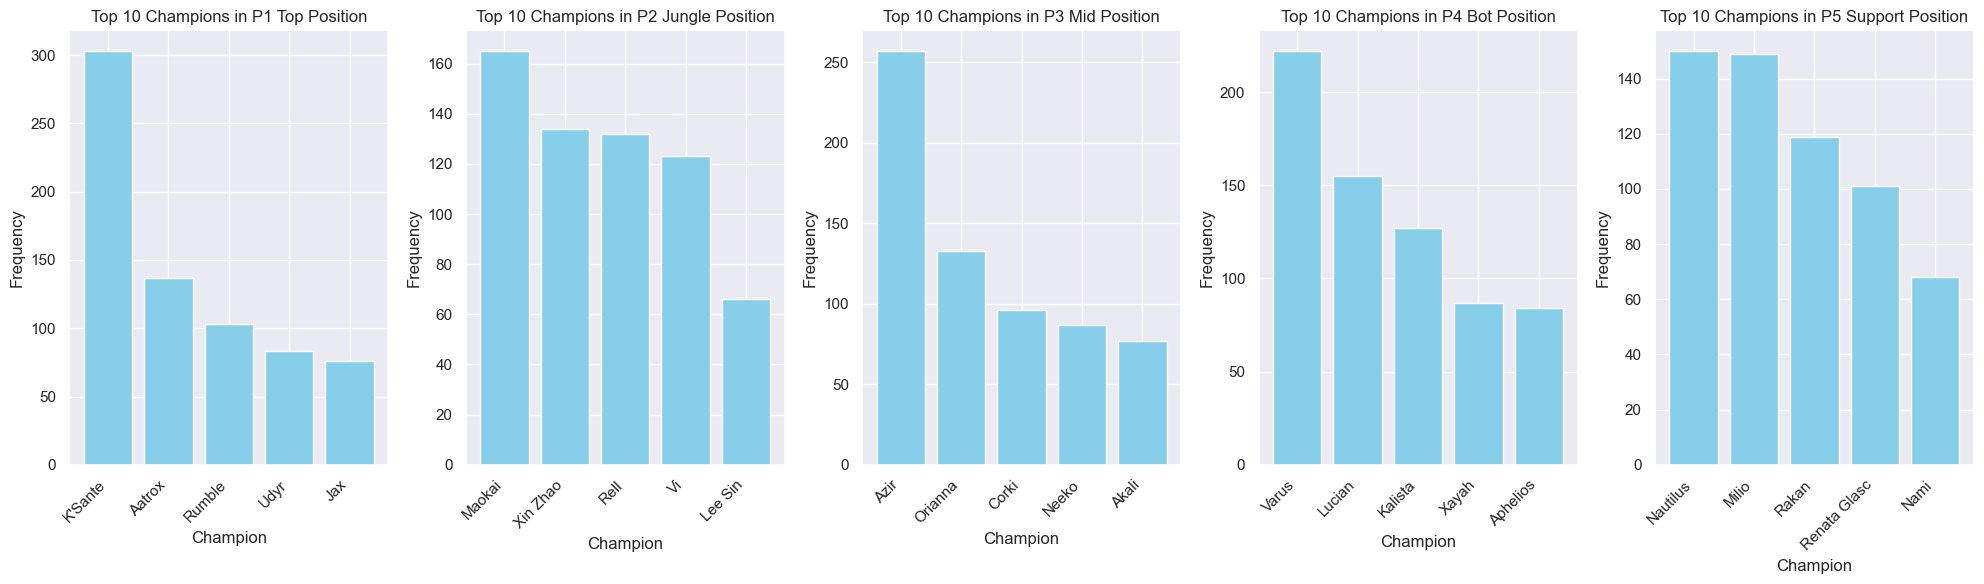

In [147]:
# Assuming 'combined_dataframe' is the name of your DataFrame
# Assuming you have already combined your dataframes and stored them in 'combined_dataframe'

# Define positions
positions = ['P1 Top', 'P2 Jungle', 'P3 Mid', 'P4 Bot', 'P5 Support']

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 6))

# Loop through positions and plot
for i, pos in enumerate(positions):
    # Count the occurrences of each champion in the current position
    top_10_champions = combined_dataframe[pos].value_counts().head(5)
    
    # Plotting
    axs[i].bar(top_10_champions.index, top_10_champions.values, color='skyblue')
    axs[i].set_title(f'Top 10 Champions in {pos} Position')
    axs[i].set_xlabel('Champion')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_xticklabels(top_10_champions.index, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

This is to show the top 5 champions in their respective roles that has the highest frequency in 'combined_dataframe'. 

In [145]:
pos = {
    1: "P1 Top",
    2: "P2 Jungle",
    3: "P3 Mid",
    4: "P4 Bot",
    5: "P5 Support",
}

for i in pos:
    numOfGamesWonBasedOnRole = 0
    top5 = combined_dataframe[pos[i]].value_counts().head(5)
    numOfGamesWonBasedOnRole += len(loldata[((loldata['t1p'+str(i)+'_champion'].isin(top5.index)) & loldata['t1_result'] == 1) | ((loldata['t2p'+str(i)+'_champion'].isin(top5.index)) & loldata['t2_result'] == 1)])
    print(numOfGamesWonBasedOnRole)
    print('\n')



702


620


650


675


587




This is to show which role has the most wins if any of the top 5 champions in that role is picked. 